In [1]:
import numpy as np
import random
from scipy.stats import norm,bernoulli
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class GPR(object):
    
    def __init__(self,x,y,noise=.1):
        self.x=x
        self.y=x
        self.noise=noise
        
        self.xmeans=self.mean_func(self.x)
        self.cov_matrix=self.cov_func(self.x,self.x)+(np.identity(len(self.x))*self.noise)
        self.inv_cov_matrix=np.linalg.inv(self.cov_matrix)
        self.det_cov_matrix=np.linalg.det(self.cov_matrix)
        
    def likelihood(self):
        return np.sum(-1/2.*np.log(self.det_cov_matrix))-(1/2.*(self.y-self.xmeans).T*self.inv_cov_matrix*(self.y-self.xmeans))-((len(self.x)/2.)*np.log(2*np.pi))
    
    def predict(self,x_):
        x_mean=[self.mean_func(x_[i]) for i in xrange(len(x_))]
        x_xcov=[self.cov_func(x_[i],self.x).T for i in xrange(len(x_))]
        x_cov=[self.cov_func(x_[i],x_[i]) for i in xrange(len(x_))]
        
        mean=np.array([x_mean[i]+x_xcov[i].T*self.inv_cov_matrix*(self.y-self.xmeans) for i in xrange(len(x_))]).reshape(len(x_))
        var=np.array([(self.noise+x_cov[i])-x_xcov[i].T*self.inv_cov_matrix*x_xcov[i] for i in xrange(len(x_))]).reshape(len(x_),1)
        return mean,var
        

class PositiveLinear(GPR):
    
    def mean_func(self,x):
        return np.array(x)
    
    def cov_func(self,x1,x2):
        return np.matrix(x1*x2.T) #variance and offset fixed at 1 and 0 for now
    
    
class NegativeLinear(GPR):
    
    def mean_func(self,x):
        return np.array(1-x)
    
    def cov_func(self,x1,x2):
        return np.matrix(x1*x2.T)
    
def mix(x,y,i):
    dist={}
    #random initial assignments
    assignments=np.random.random_integers(0,1,len(x))
    for i in xrange(i*len(x)):
        #in the full model each expert's hyperparameters are optimized for each new partitioning
        #randomly choose assignment
        index=np.random.choice(xrange(len(x)))
        #initialize experts with subsets of x and y according to assignments, excluding randomly chosen assignment
        PL=PositiveLinear(np.array([x[j] for j in xrange(len(x)) if assignments[j]==0 and x[j] != x[index]]),
                               np.array([y[j] for j in xrange(len(y)) if assignments[j]==0 and y[j] != y[index]]))
        NL=NegativeLinear(np.array([x[j] for j in xrange(len(x)) if assignments[j]==1 and x[j] != x[index]]),
                               np.array([y[j] for j in xrange(len(y)) if assignments[j]==1 and y[j] != y[index]]))
        #likelihood of the randomly chosen assignment given each expert
        ratio=[np.sum(norm(*PL.predict(x[index])).pdf(y[index])),np.sum(norm(*NL.predict(x[index])).pdf(y[index]))]
        constant=sum(ratio)
        if constant>0:
            normalized=[ratio[0]/constant,ratio[1]/constant]
            #draw expert from likelihood ratio
            new_assignment=bernoulli(normalized[1]).rvs()
            #reassign
            assignments[index]=new_assignment
            if i>100*len(x):
                if tuple(assignments) in dist:
                    dist[tuple(assignments)]+=1
                else:
                    dist[tuple(assignments)]=1
    #return assignments
    return max(dist,key=dist.get)

def inference(priors,assignments,x,y,x_,i,bins):
    bins=np.linspace(0,1,bins)
    dist={xi:[0 for n in bins] for xi in xrange(len(x_))}
    #initialize experts with given assignments
    experts=[PositiveLinear(np.array([x[i] for i in xrange(len(x)) if assignments[i]==0]),np.array([y[i] for i in xrange(len(y)) if assignments[i]==0])),
            NegativeLinear(np.array([x[i] for i in xrange(len(x)) if assignments[i]==1]),np.array([y[i] for i in xrange(len(y)) if assignments[i]==1]))]
    for i in xrange(i):
        #draw from prior over experts
        expert=experts[bernoulli(priors[1]).rvs()]
        means,covs=expert.predict(x_)
        #draw predictions from chosen expert's predictive posterior
        predictions=[np.sum(norm(means[j],covs[j]).rvs()) for j in xrange(len(means))]
        for xi in xrange(len(x_)):
            for b in xrange(len(bins)):
                if predictions[xi]>bins[b]:
                    dist[xi][b-1]+=1
    normalized_dist={}
    for key in dist.keys():
        constant=sum(dist[key])
        normalized_dist[key]=[p/constant for p in dist[key]]
    return normalized_dist

In [3]:
X = np.random.uniform(0.,1.,(40,1))
true_assignments = np.array([np.array(random.choice([(0,1),(1,-1)])) for i in xrange(len(X))])
Y = np.sum(np.hstack((np.ones(len(X))[None].T,X)) * true_assignments,axis=1)[None].T

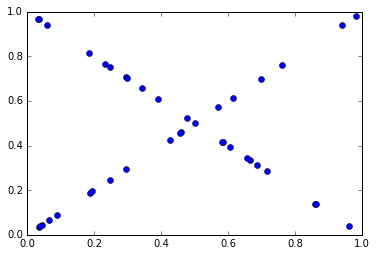

In [4]:
plt.plot(X,Y,'bo')
plt.show()

(1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1)


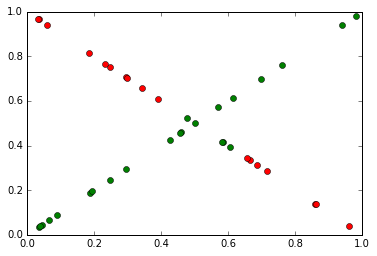

In [5]:
assignments=mix(X,Y,3000)
print assignments
PLx=np.array([X[i] for i in xrange(len(X)) if assignments[i]==0])
PLy=np.array([Y[i] for i in xrange(len(Y)) if assignments[i]==0])
NLx=np.array([X[i] for i in xrange(len(X)) if assignments[i]==1])
NLy=np.array([Y[i] for i in xrange(len(Y)) if assignments[i]==1])

plt.plot(PLx,PLy,'go') #points assigned to positive linear expert
plt.plot(NLx,NLy,'ro') #points assigned to negative linear expert
plt.show()

In [6]:
priors=(.5,.5)
x_=np.linspace(0,1)[None].T
results=inference(priors,assignments,X,Y,x_,100,100)
